In [1]:
import numpy as np
import matplotlib.pyplot as plt
import logging
import io
import requests
import ipywidgets as widgets  # For interactive display
from scipy import stats

## Figure Settings

In [2]:
# Configure matplotlib settings
logging.getLogger('matplotlib.font_manager').disabled = True
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [3]:
# Plotting functions
def plot_isis(single_neuron_isis):
  plt.hist(single_neuron_isis, bins=50, histtype="stepfilled")
  plt.axvline(single_neuron_isis.mean(), color="orange", label="Mean ISI")
  plt.xlabel("ISI duration (s)")
  plt.ylabel("Number of spikes")
  plt.legend()

## Data Retrieval

In [4]:
r = requests.get('https://osf.io/sy5xt/download')
if r.status_code != 200:
  print('Failed to download data')
else:
  spike_times = np.load(io.BytesIO(r.content), allow_pickle=True)['spike_times']

In [8]:
# Display the type and shape of the spike_times array
type(spike_times), spike_times.shape

(numpy.ndarray, (734,))

In [9]:
# It shows that the first element is also a NumPy array, which is a one-dimensional array with 826 elements
idx = 0
print(
  type(spike_times[idx]),
  spike_times[idx].shape,
  sep="\n",
) 

<class 'numpy.ndarray'>
(826,)


In [11]:
# Spike_times[321] is also a NumPy array and this array has 9723 elements.
idx = 321
print(
  type(spike_times[idx]),
  spike_times[idx].shape,
  sep="\n",
) 

<class 'numpy.ndarray'>
(9723,)


In [12]:
# These two arrays contain floating point numbers (“floats”) with 32 bits of precision.
i_neurons = [0, 321]
i_print = slice(0, 5)

for i in i_neurons:
  print(
    "Neuron {}:".format(i),
    spike_times[i].dtype,
    spike_times[i][i_print],
    "\n",
    sep="\n"
  )

Neuron 0:
float32
[ 0.8149   14.822467 24.9646   25.1436   38.8709  ]


Neuron 321:
float32
[1.0698667 1.1536334 1.2403667 1.7072    1.799    ]




`spike_times` is 1D, its entries are NumPy arrays, and its length is the number of neurons (734): by indexing it, we select a subset of neurons. An array in `spike_times` is also 1D and corresponds to a single neuron; its entries are floating point numbers, and its length is the number of spikes attributed to that neuron. By indexing it, we select a subset of spike times for that neuron.

In [13]:
n_neurons = len(spike_times)
total_spikes_per_neuron = [len(spike_times_i) for spike_times_i in spike_times]

print(f"Number of neurons: {n_neurons}")
print(f"Number of spikes for first five neurons: {total_spikes_per_neuron[:5]}")

Number of neurons: 734
Number of spikes for first five neurons: [826, 2818, 3953, 646, 1115]


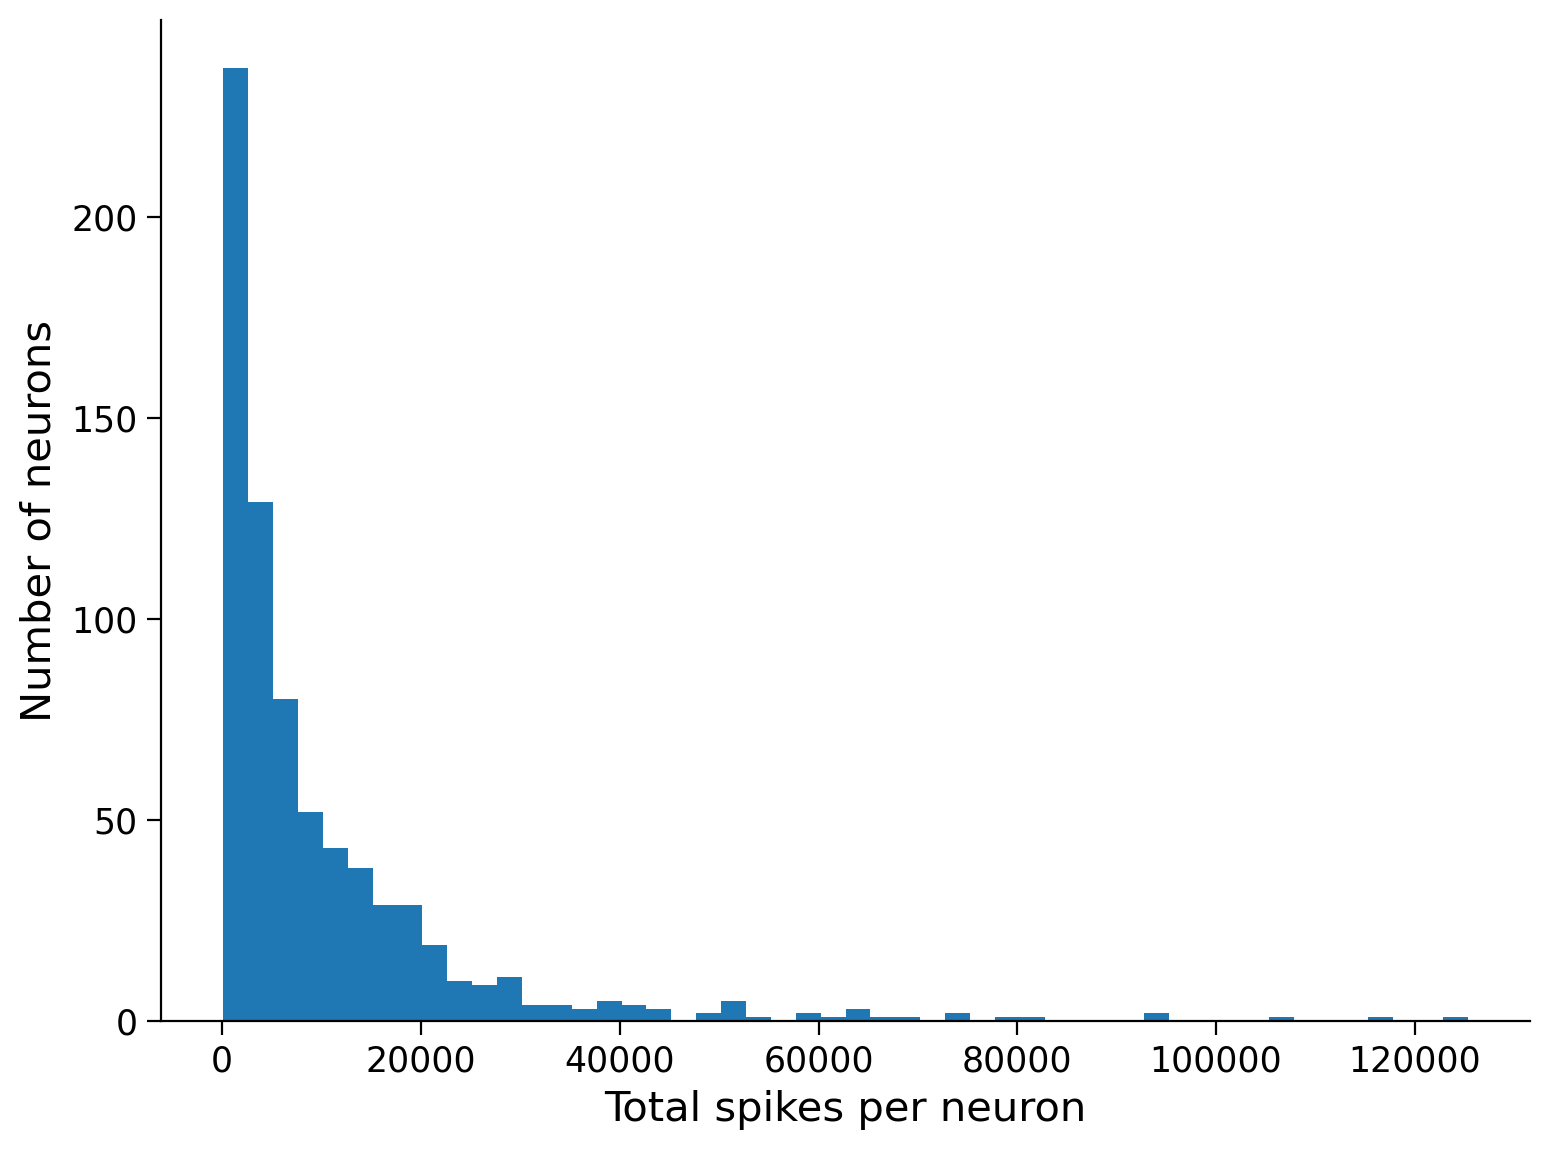

In [11]:
plt.hist(total_spikes_per_neuron, bins=50, histtype="stepfilled")
plt.xlabel("Total spikes per neuron")
plt.ylabel("Number of neurons");
# In the graph, neurons with 0 to 10,000 spikes have the highest number.
# Y axsis: It represents the number of neurons that have a given spike count.

In [14]:
# More than 68% of neurons produce fewer than average spikes.
mean_spike_count = np.mean(total_spikes_per_neuron)
frac_below_mean = (total_spikes_per_neuron < mean_spike_count).mean()
print(f"{frac_below_mean:2.1%} of neurons are below the mean") 

68.0% of neurons are below the mean


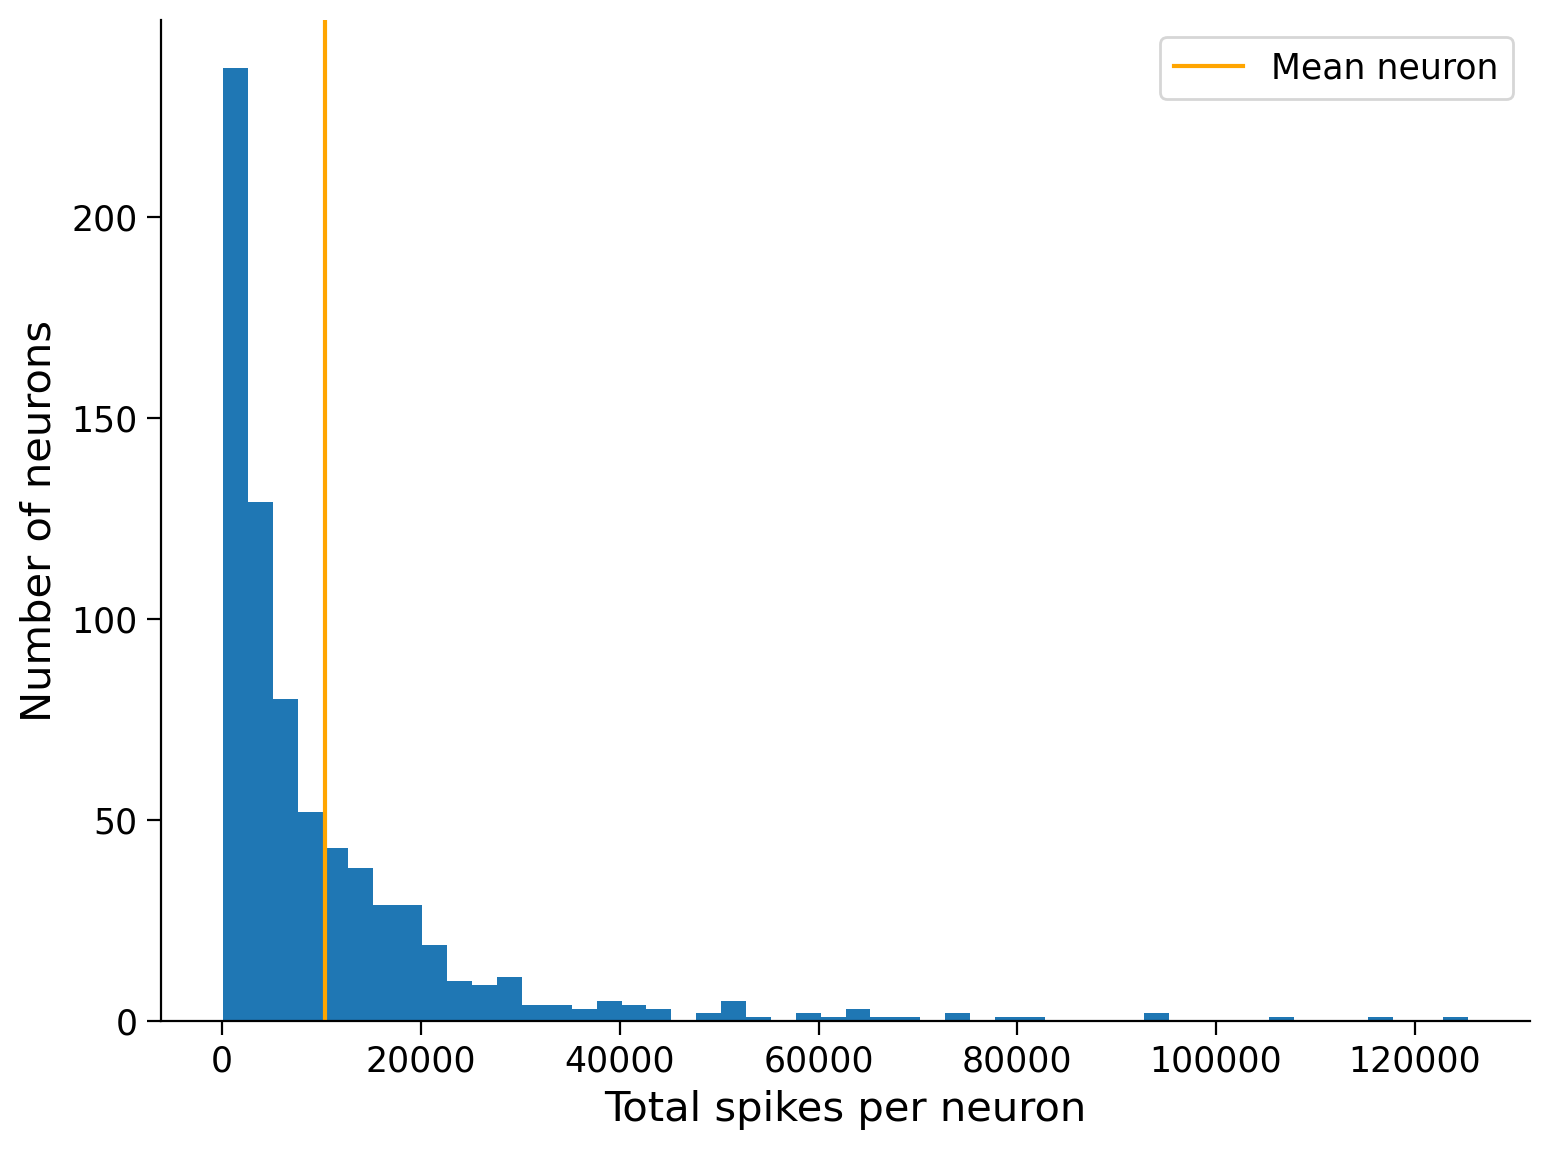

In [15]:
plt.hist(total_spikes_per_neuron, bins=50, histtype="stepfilled")
plt.xlabel("Total spikes per neuron")
plt.ylabel("Number of neurons")
plt.axvline(mean_spike_count, color="orange", label="Mean neuron")
plt.legend();

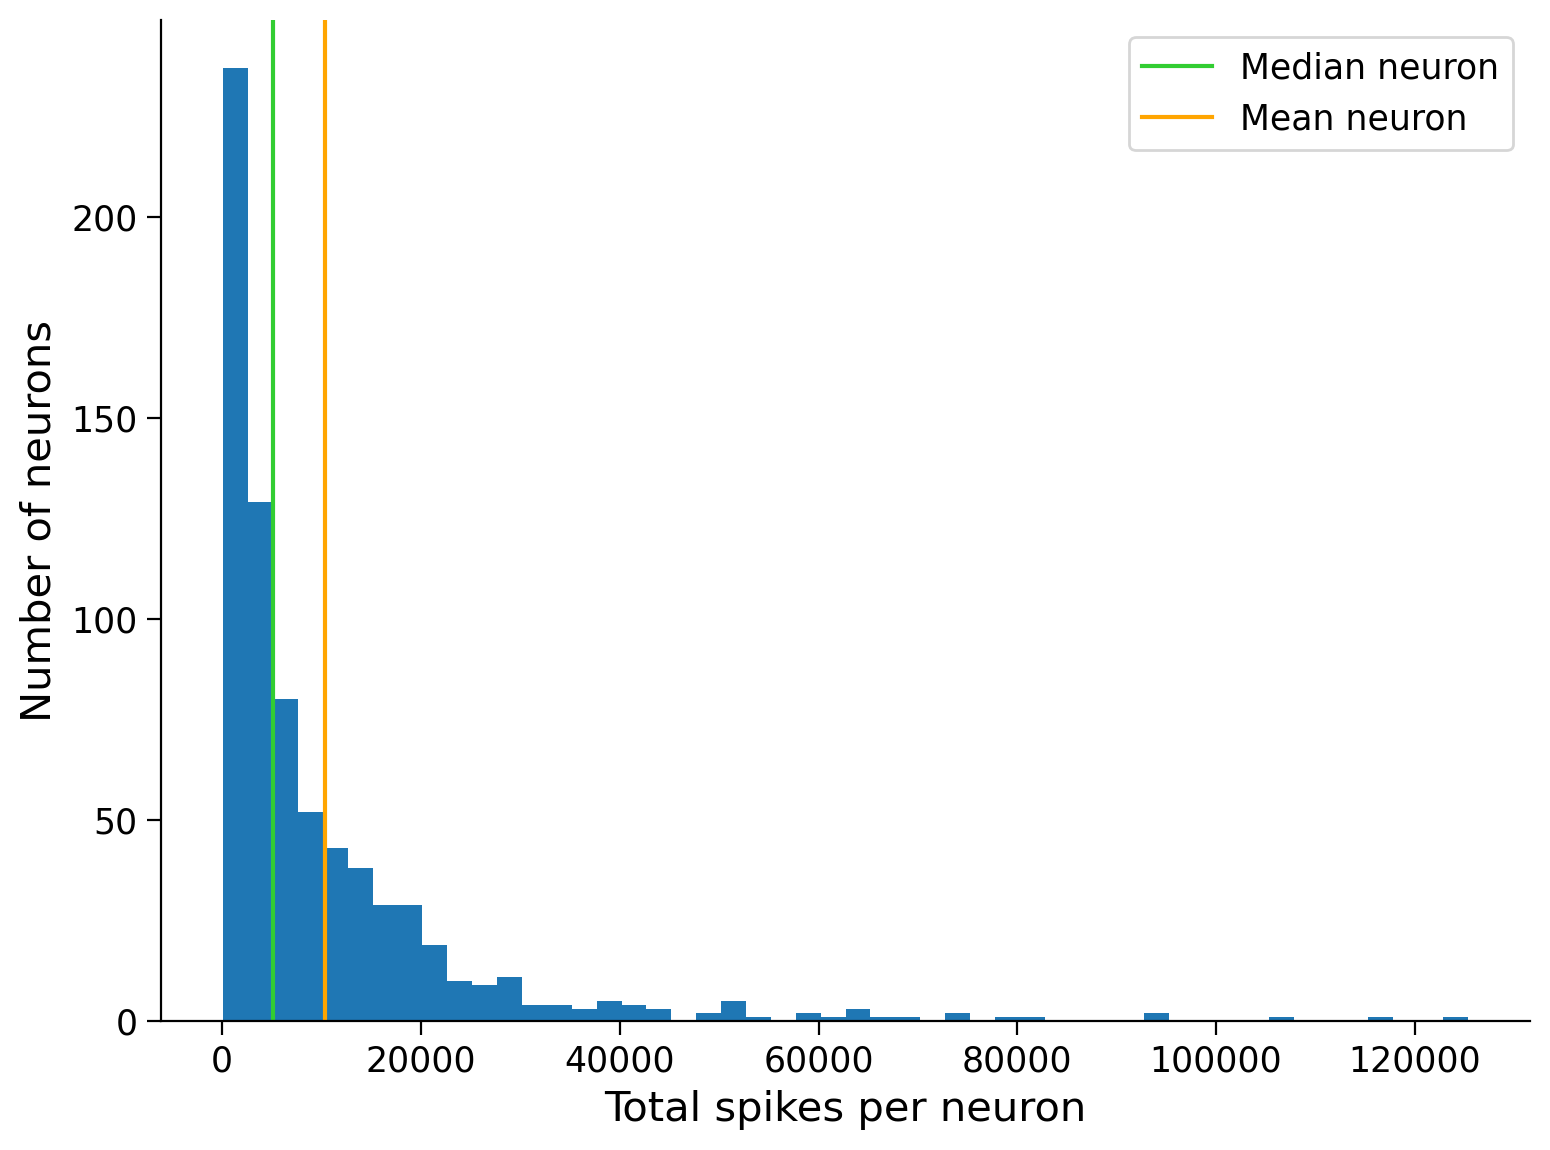

In [16]:
# Compute median spike count
median_spike_count =  np.median(total_spikes_per_neuron) # Hint: Try the function np.median
# Visualize median, mean, and histogram
plt.hist(total_spikes_per_neuron, bins=50, histtype="stepfilled")
plt.axvline(median_spike_count, color="limegreen", label="Median neuron")
plt.axvline(mean_spike_count, color="orange", label="Mean neuron")
plt.xlabel("Total spikes per neuron")
plt.ylabel("Number of neurons")
plt.legend()
# Median is the 50th percentile of the dataset 
# IQR = Q3 - Q1

## Show the Interquartile Range on the Histogram

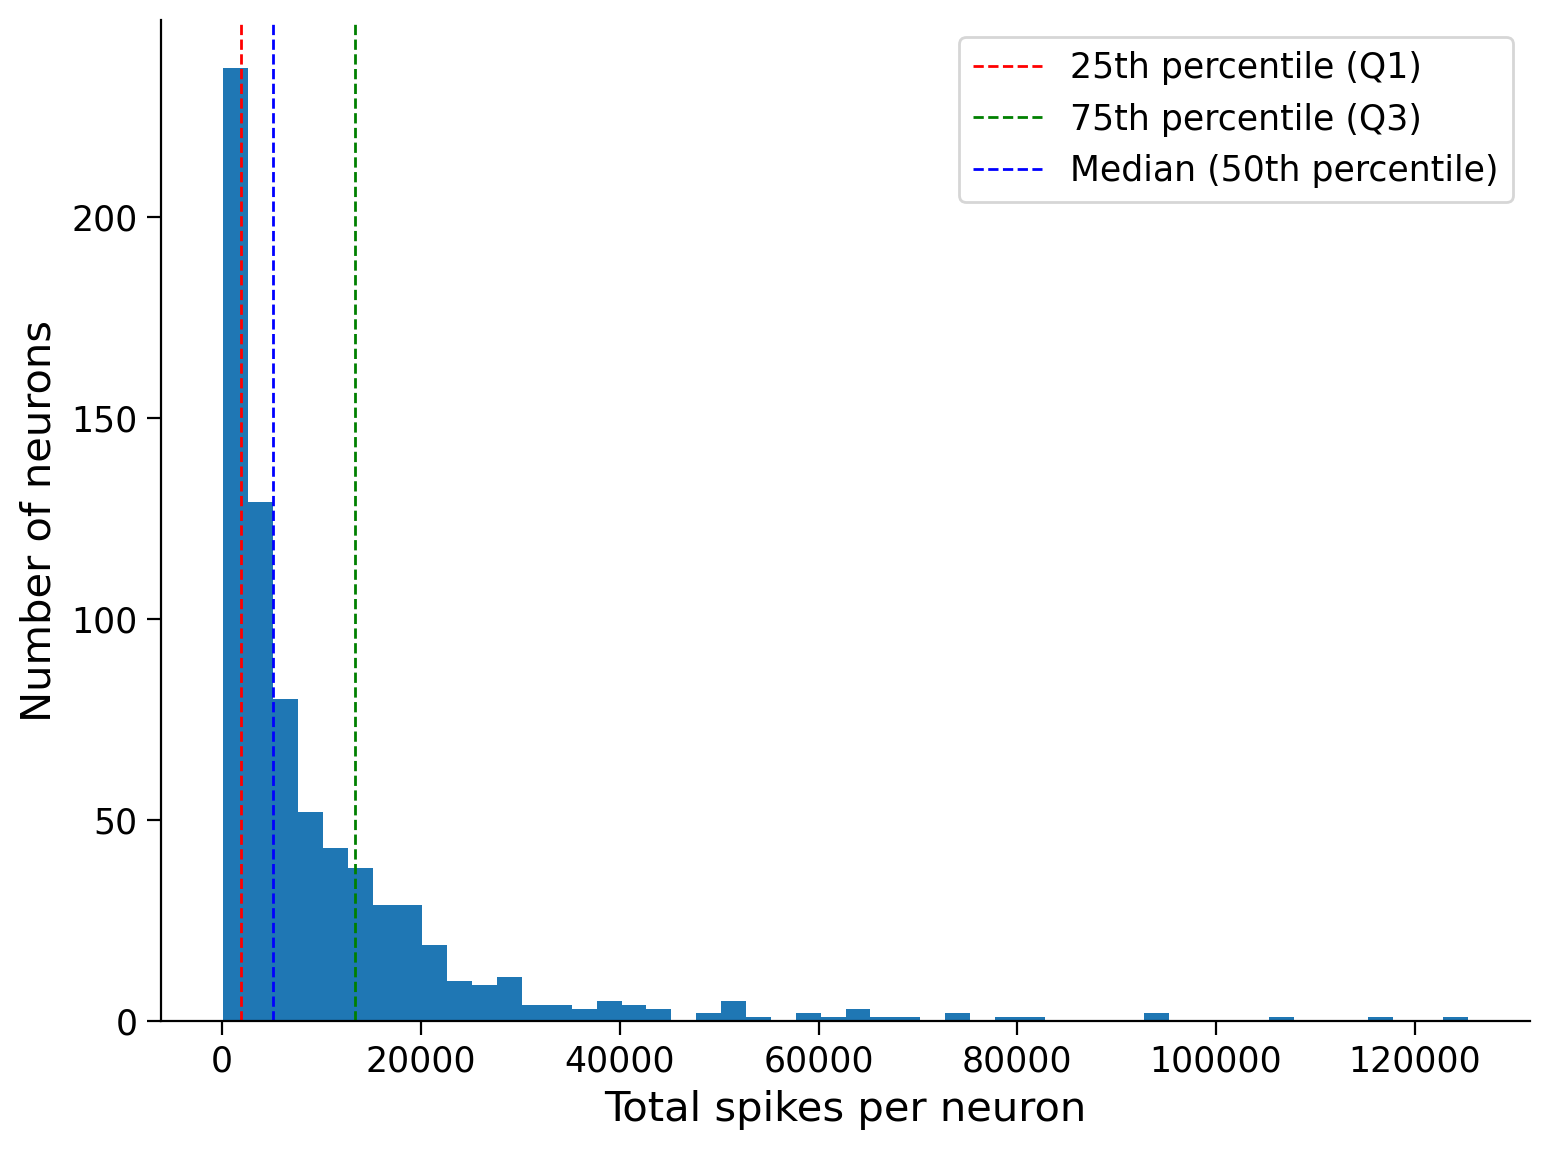

(<matplotlib.legend.Legend at 0x255427dac80>, None)

In [17]:
Q1 = np.percentile(total_spikes_per_neuron, 25)
Q3 = np.percentile(total_spikes_per_neuron, 75)
IQR = Q3 - Q1
plt.hist(total_spikes_per_neuron, bins=50, histtype="stepfilled")
plt.xlabel("Total spikes per neuron")
plt.ylabel("Number of neurons")
plt.axvline(Q1, color='r', linestyle='dashed', linewidth=1, label='25th percentile (Q1)')
plt.axvline(Q3, color='g', linestyle='dashed', linewidth=1, label='75th percentile (Q3)')
plt.axvline(np.median(total_spikes_per_neuron), color='b', linestyle='dashed', linewidth=1, label='Median (50th percentile)')
plt.legend(), plt.show()

In [18]:
def restrict_spike_times(spike_times, interval):
  """Given a spike_time dataset, restrict to spikes within given interval.

  Args:
    spike_times (sequence of np.ndarray): List or array of arrays,
      each inner array has spike times for a single neuron.
    interval (tuple): Min, max time values; keep min <= t < max.

  Returns:
    np.ndarray: like `spike_times`, but only within `interval`
  """
  interval_spike_times = []
  for spikes in spike_times:
    interval_mask = (spikes >= interval[0]) & (spikes < interval[1])
    interval_spike_times.append(spikes[interval_mask])
  return np.array(interval_spike_times, object)

In [19]:
help(restrict_spike_times)

Help on function restrict_spike_times in module __main__:

restrict_spike_times(spike_times, interval)
    Given a spike_time dataset, restrict to spikes within given interval.
    
    Args:
      spike_times (sequence of np.ndarray): List or array of arrays,
        each inner array has spike times for a single neuron.
      interval (tuple): Min, max time values; keep min <= t < max.
    
    Returns:
      np.ndarray: like `spike_times`, but only within `interval`



In [20]:
t_interval = (5, 15)  # Units are seconds after start of recording
# Each inner arrays are subsets of spike times for that neuron
interval_spike_times = restrict_spike_times(spike_times, t_interval)
# interval (tuple): Min, max time values; keep min <= t < max.

In [21]:
# Represents the total number of spikes for all neurons.
original_counts = sum([len(spikes) for spikes in spike_times])
# Represents the total number of spikes occurring in a given time period. 
interval_counts = sum([len(spikes) for spikes in interval_spike_times])
# Calculates the ratio of the number of spikes in a certain time interval to the total number of spikes.
frac_interval_spikes = interval_counts / original_counts
print(f"{frac_interval_spikes:.2%} of the total spikes are in the interval")

0.33% of the total spikes are in the interval


`We can approximate the experiment duration by taking the minimum and maximum spike time in the whole dataset. To do that, we “concatenate” all of the neurons into one array and then use np.ptp (“peak-to-peak”) to get the difference between the maximum and minimum value:`

In [20]:
spike_times_flat = np.concatenate(spike_times) # Whole spike times which are in the dataset 
experiment_duration = np.ptp(spike_times_flat) # Differences between max and min value of cancataneted dataset 
interval_duration = t_interval[1] - t_interval[0]
frac_interval_time = interval_duration / experiment_duration
print(f"{frac_interval_time:.2%} of the total time is in the interval") 

0.37% of the total time is in the interval


##  Conclusion: 
These two values—the fraction of total spikes and the fraction of total time—are similar. This suggests the average spike rate of the neuronal population is not very different in this interval compared to the entire recording.

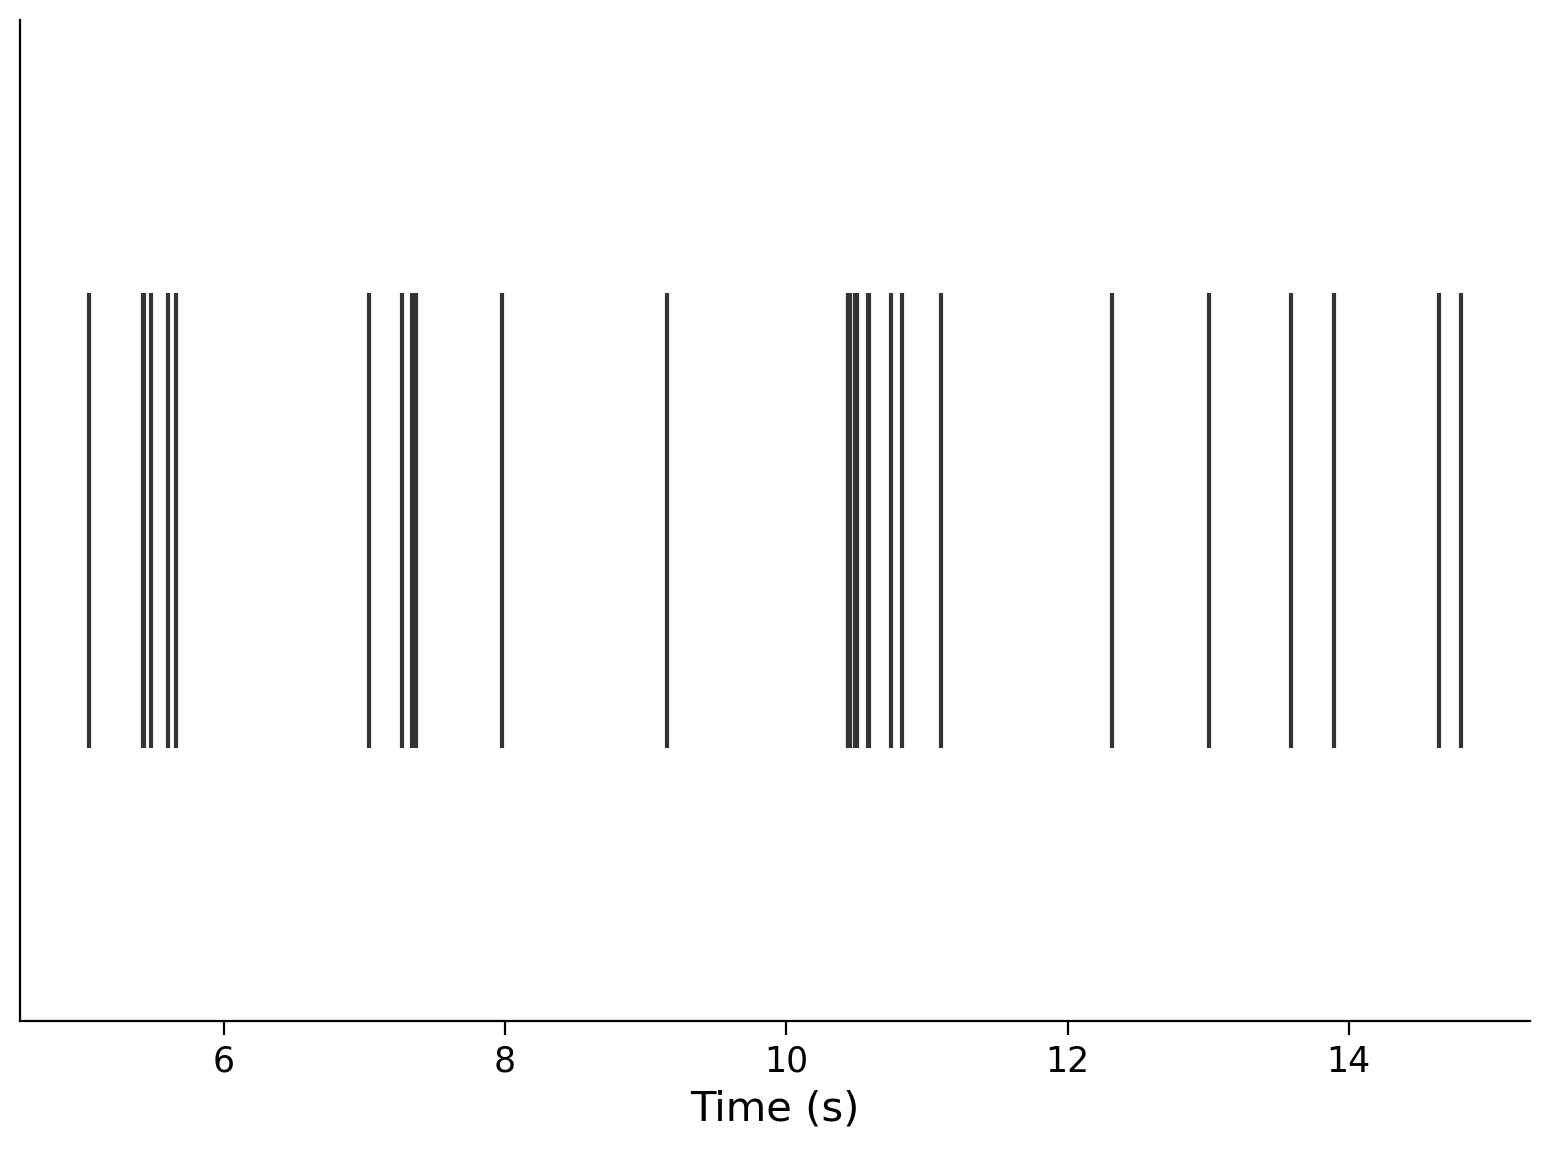

In [22]:
neuron_idx = 1
plt.eventplot(interval_spike_times[neuron_idx], color=".2") # tam olarak 1. nöronda ne zaman spkie olmui hangi aralıklarla ve hangi sıklıklarla olmuş görebilityoruz. 
plt.xlabel("Time (s)")
plt.yticks([]);

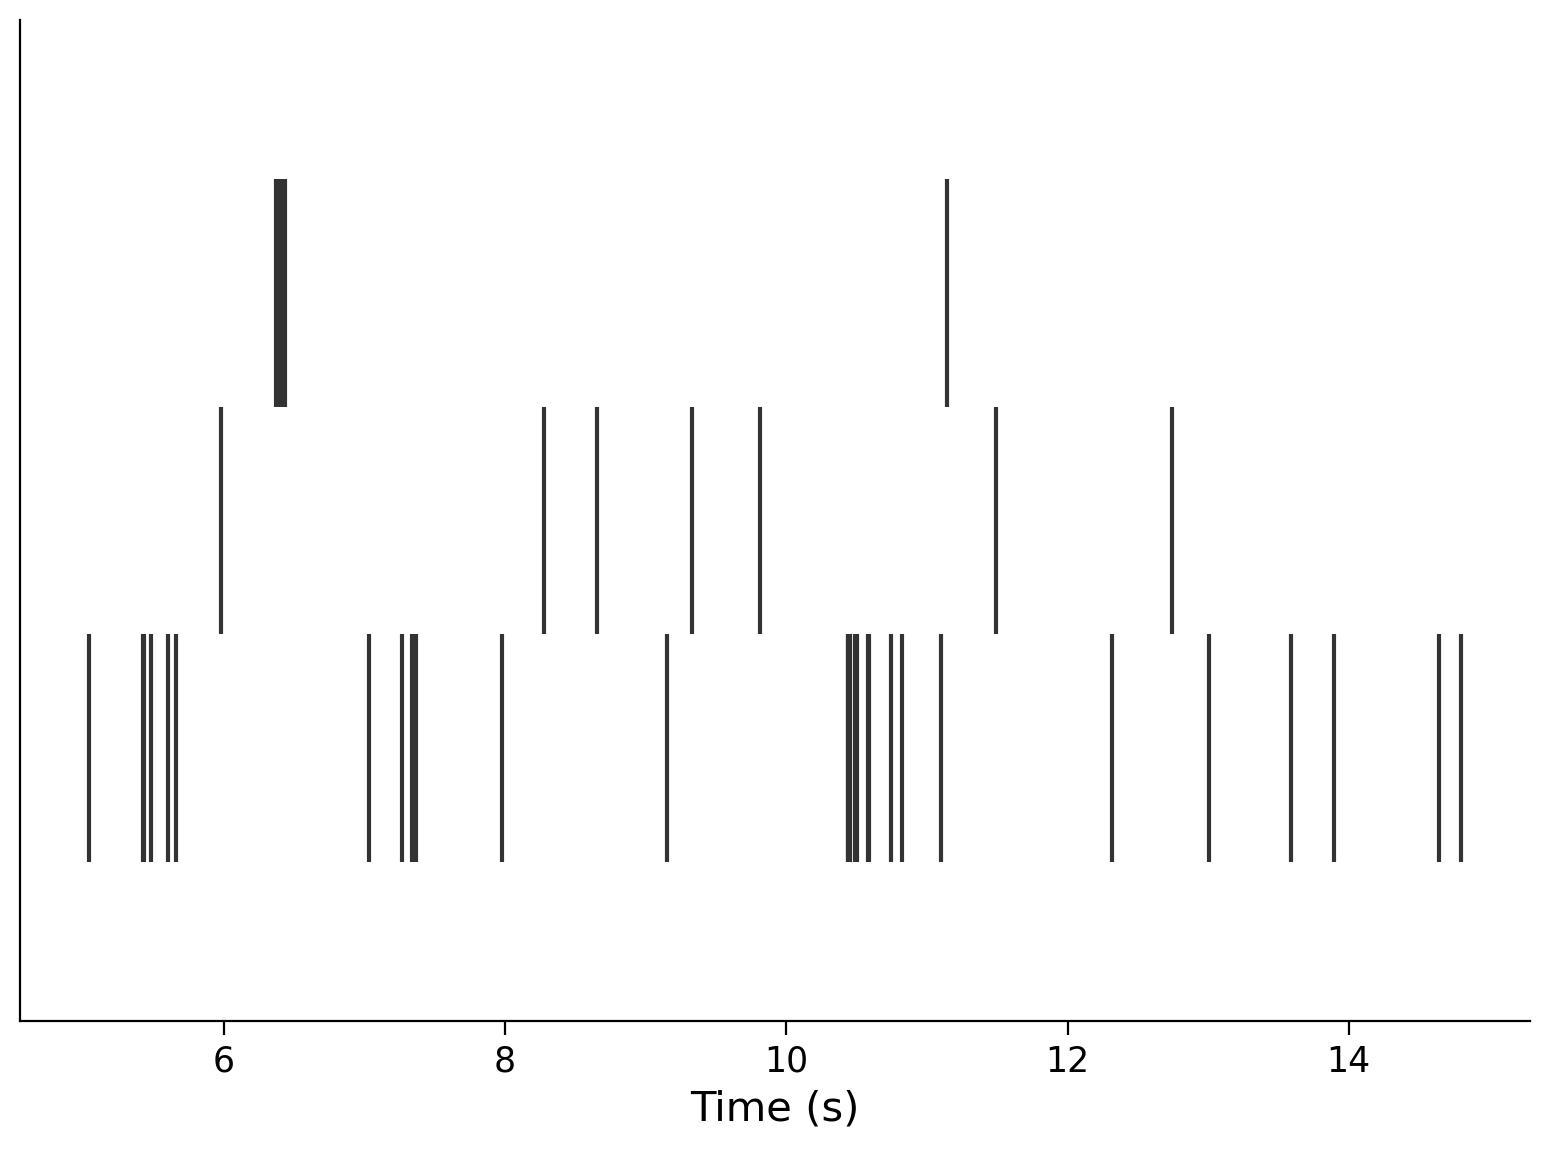

In [24]:
neuron_idx = [1, 11, 51]
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);

`Plotting a large number of neurons can give you a sense for the characteristics in the population. Let’s show every 5th neuron that was recorded:`

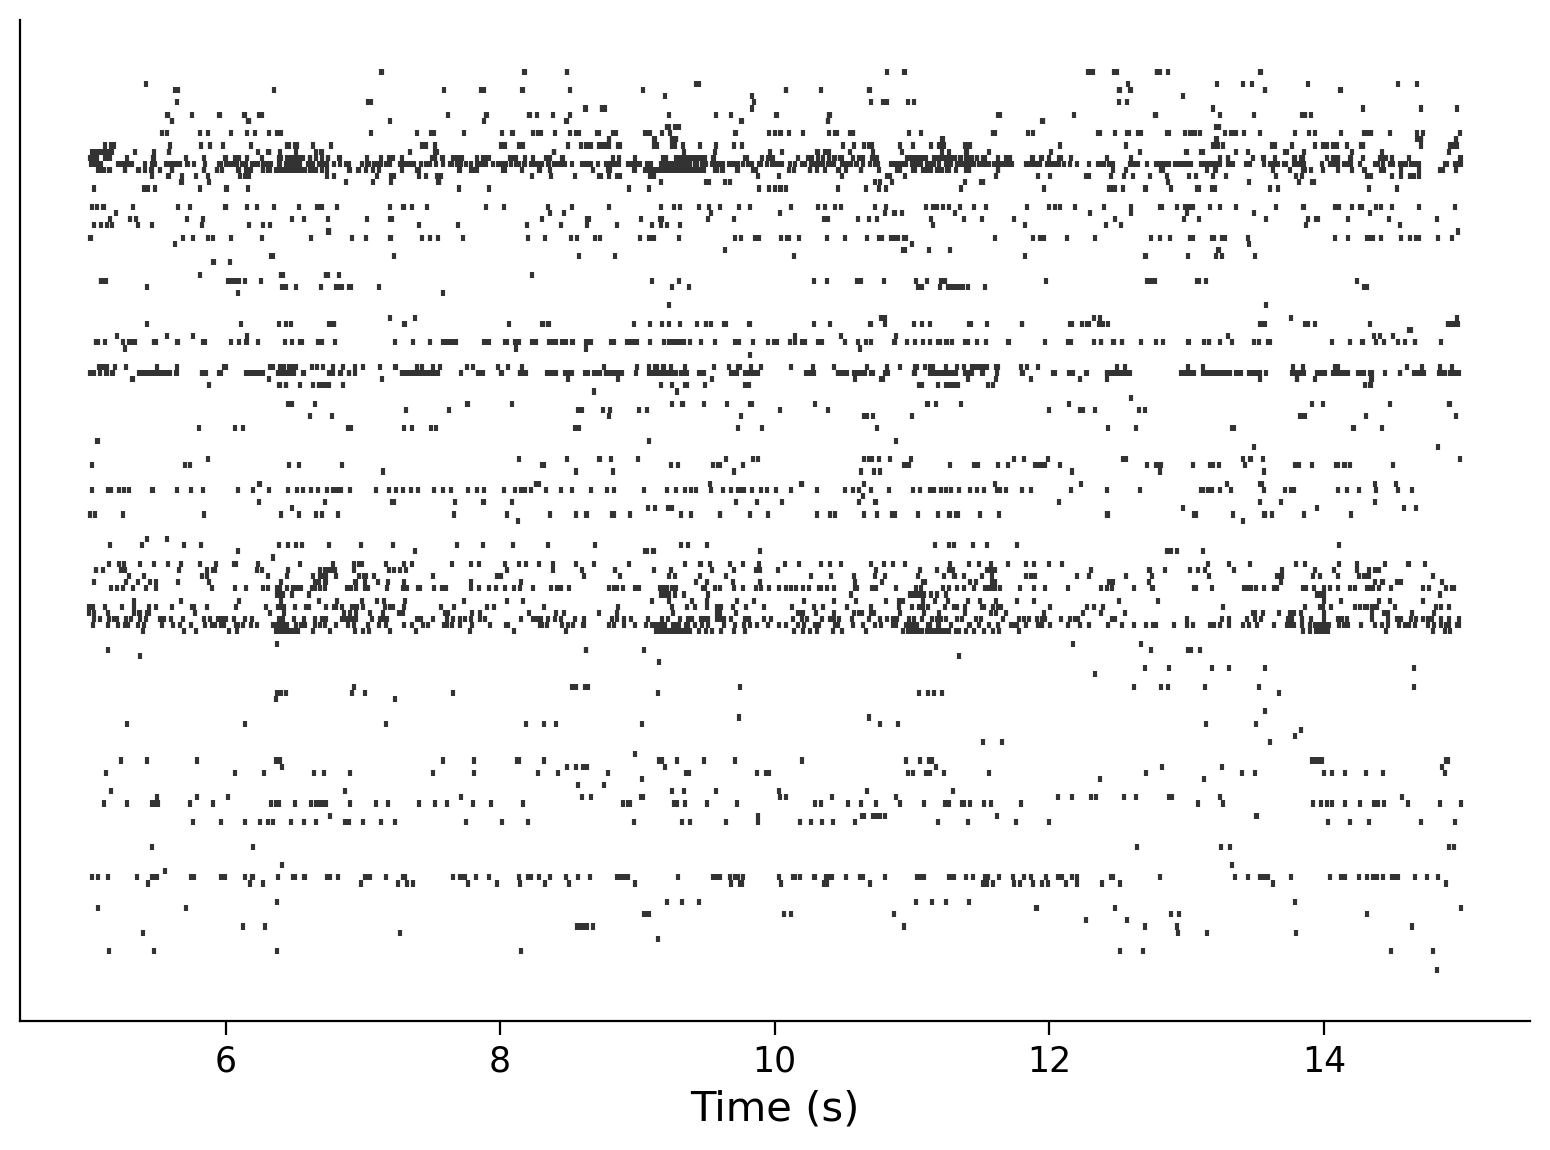

In [25]:
neuron_idx = np.arange(0, len(spike_times), 5)
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);

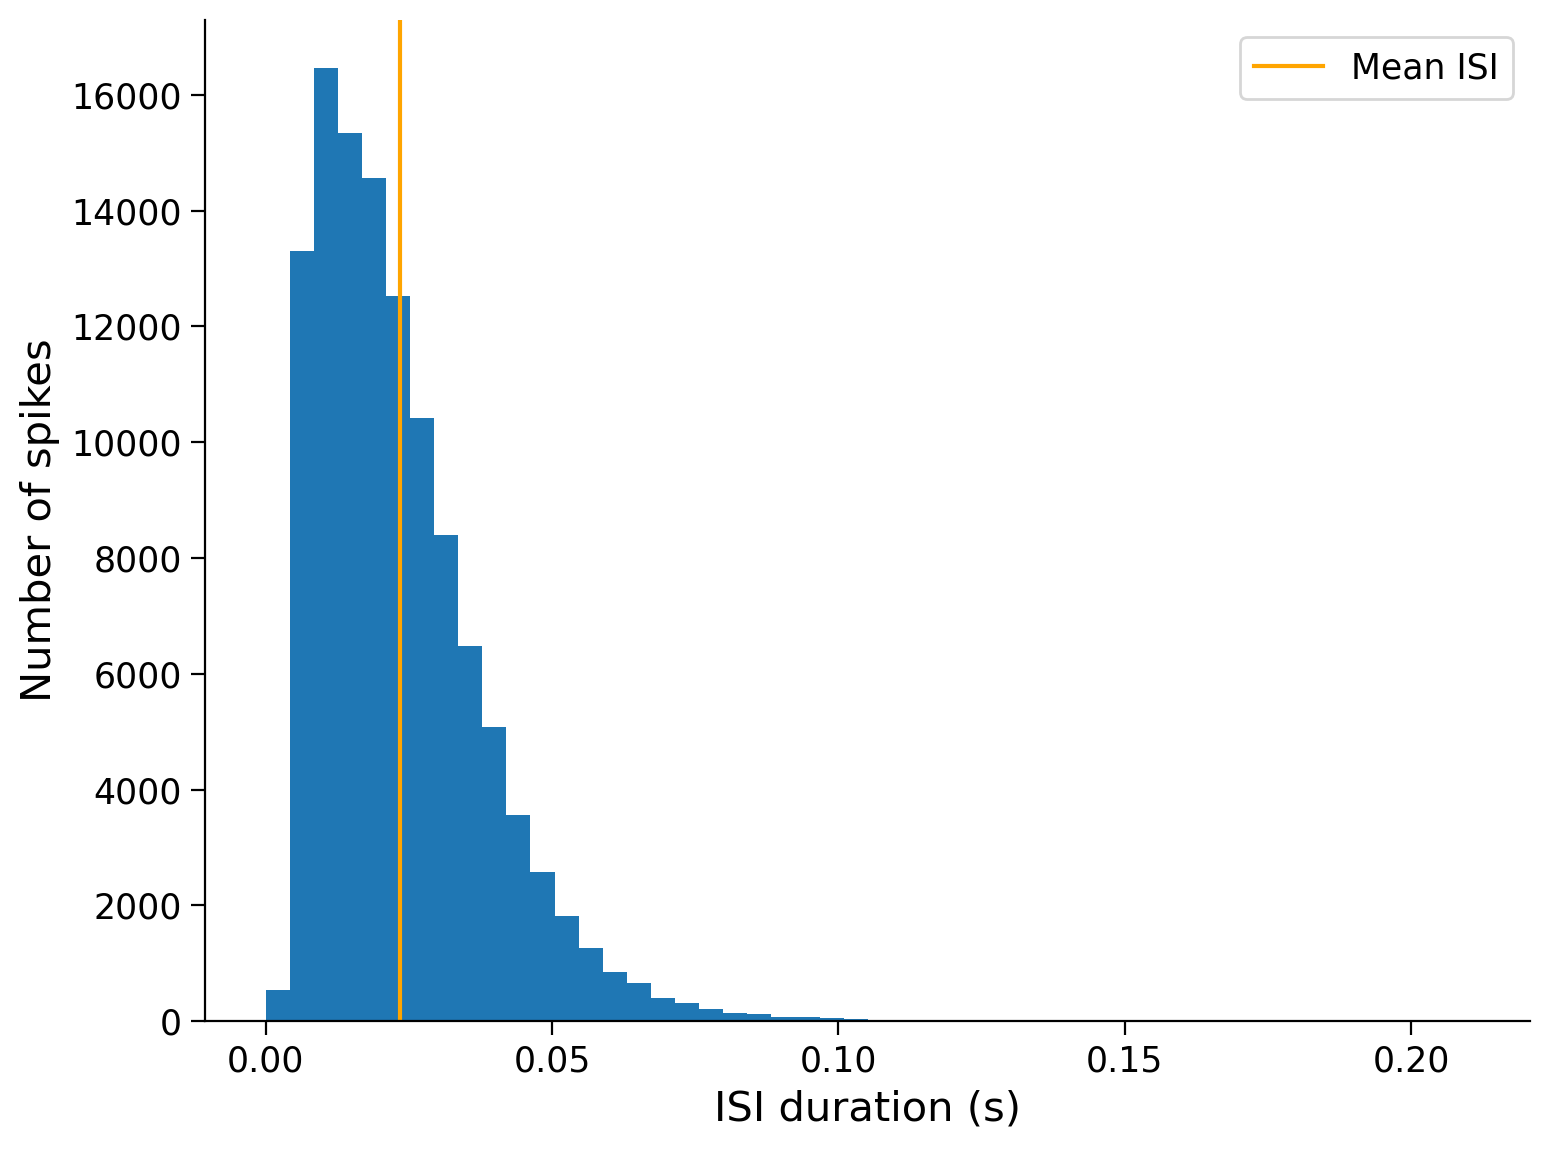

In [26]:
def compute_single_neuron_isis(spike_times, neuron_idx):
  """Compute a vector of ISIs for a single neuron given spike times.

  Args:
    spike_times (list of 1D arrays): Spike time dataset, with the first
      dimension corresponding to different neurons.
    neuron_idx (int): Index of the unit to compute ISIs for.

  Returns:
    isis (1D array): Duration of time between each spike from one neuron.
  """
  single_neuron_spikes = spike_times[neuron_idx]
  isis = np.diff(single_neuron_spikes)
  return isis

# Compute ISIs
single_neuron_isis = compute_single_neuron_isis(spike_times, neuron_idx=283)
# Visualize ISIs
plot_isis(single_neuron_isis)

`Define a few different function forms that we might expect the relationship to follow: exponential, inverse, and linear.`

In [28]:
def exponential(xs, scale, rate, x0):
  """A simple parameterized exponential function, applied element-wise.

  Args:
    xs (np.ndarray or float): Input(s) to the function.
    scale (float): Linear scaling factor.
    rate (float): Exponential growth (positive) or decay (negative) rate.
    x0 (float): Horizontal offset.

  """
  ys = scale * np.exp(rate * (xs - x0))
  return ys

def inverse(xs, scale, x0):
  """A simple parameterized inverse function (`1/x`), applied element-wise.

  Args:
    xs (np.ndarray or float): Input(s) to the function.
    scale (float): Linear scaling factor.
    x0 (float): Horizontal offset.

  """
  ys = scale / (xs - x0)
  return ys

def linear(xs, slope, y0):
  """A simple linear function, applied element-wise.

  Args:
    xs (np.ndarray or float): Input(s) to the function.
    slope (float): Slope of the line.
    y0 (float): y-intercept of the line.

  """
  ys = slope * xs + y0
  return ys

`If you have trouble understanding under cell's code, you can ignore it.`

In [29]:
# It's to setup an interactive plot.
single_neuron_idx = 283
single_neuron_spikes = spike_times[single_neuron_idx]
single_neuron_isis = np.diff(single_neuron_spikes)

counts, edges = np.histogram(
  single_neuron_isis,
  bins=50,
  range=(0, single_neuron_isis.max())
)

functions = dict(
  exponential=exponential,
  inverse=inverse,
  linear=linear,
)

colors = dict(
  exponential="C1",
  inverse="C2",
  linear="C4",
)

@widgets.interact(
  exp_scale=widgets.FloatSlider(1000, min=0, max=20000, step=250),
  exp_rate=widgets.FloatSlider(-10, min=-200, max=50, step=1),
  exp_x0=widgets.FloatSlider(0.1, min=-0.5, max=0.5, step=0.005),
  inv_scale=widgets.FloatSlider(1000, min=0, max=3e2, step=10),
  inv_x0=widgets.FloatSlider(0, min=-0.2, max=0.2, step=0.01),
  lin_slope=widgets.FloatSlider(-1e5, min=-6e5, max=1e5, step=10000),
  lin_y0=widgets.FloatSlider(10000, min=0, max=4e4, step=1000),
)
def fit_plot(
  exp_scale=1000, exp_rate=-10, exp_x0=0.1,
  inv_scale=1000, inv_x0=0,
  lin_slope=-1e5, lin_y0=2000,
):
  """Helper function for plotting function fits with interactive sliders."""
  func_params = dict(
    exponential=(exp_scale, exp_rate, exp_x0),
    inverse=(inv_scale, inv_x0),
    linear=(lin_slope, lin_y0),
  )
  f, ax = plt.subplots()
  ax.fill_between(edges[:-1], counts, step="post", alpha=.5)
  xs = np.linspace(1e-10, edges.max())
  for name, function in functions.items():
    ys = function(xs, *func_params[name])
    ax.plot(xs, ys, lw=3, color=colors[name], label=name);
  ax.set(
      xlim=(edges.min(), edges.max()),
      ylim=(0, counts.max() * 1.1),
      xlabel="ISI (s)",
      ylabel="Number of spikes",
  )
  ax.legend()
  plt.show()


interactive(children=(FloatSlider(value=1000.0, description='exp_scale', max=20000.0, step=250.0), FloatSlider…

## The exponential function can be made to fit the data much better than the linear or inverse function

In [31]:
# Plotting Functions

def histogram(counts, bins, vlines=(), ax=None, ax_args=None, **kwargs):
  """Plot a step histogram given counts over bins."""
  if ax is None:
    _, ax = plt.subplots()

  # duplicate the first element of `counts` to match bin edges
  counts = np.insert(counts, 0, counts[0])

  ax.fill_between(bins, counts, step="pre", alpha=0.4, **kwargs)  # area shading
  ax.plot(bins, counts, drawstyle="steps", **kwargs)  # lines

  for x in vlines:
    ax.axvline(x, color='r', linestyle='dotted')  # vertical line

  if ax_args is None:
    ax_args = {}

  # heuristically set max y to leave a bit of room
  ymin, ymax = ax_args.get('ylim', [None, None])
  if ymax is None:
    ymax = np.max(counts)
    if ax_args.get('yscale', 'linear') == 'log':
      ymax *= 1.5
    else:
      ymax *= 1.1
      if ymin is None:
        ymin = 0

  if ymax == ymin:
    ymax = None

  ax_args['ylim'] = [ymin, ymax]

  ax.set(**ax_args)
  ax.autoscale(enable=False, axis='x', tight=True)

def plot_neuron_stats(v, spike_times):
  fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

  # membrane voltage trace
  ax1.plot(v[0:100])
  ax1.set(xlabel='Time', ylabel='Voltage')
  # plot spike events
  for x in spike_times:
    if x >= 100:
      break
    ax1.axvline(x, color='red')

  # ISI distribution
  if len(spike_times)>1:
    isi = np.diff(spike_times)
    n_bins = np.arange(isi.min(), isi.max() + 2) - .5
    counts, bins = np.histogram(isi, n_bins)
    vlines = []
    if len(isi) > 0:
      vlines = [np.mean(isi)]
    xmax = max(20, int(bins[-1])+5)
    histogram(counts, bins, vlines=vlines, ax=ax2, ax_args={
      'xlabel': 'Inter-spike interval',
      'ylabel': 'Number of intervals',
      'xlim': [0, xmax]
    })
  else:
    ax2.set(xlabel='Inter-spike interval',
           ylabel='Number of intervals')
  plt.show()

## Compute the change in voltage dV_t (per timestep) of the linear integrate-and-fire model neuron. 
* LIF simulates the neuron model and visualizes the results. During the simulation, the membrane voltage and firing times of the neuron are calculated and then these data are displayed with graphs.
* Note that we only considered excitatory behavior – the only way the membrane potential could decrease was upon a spike event.

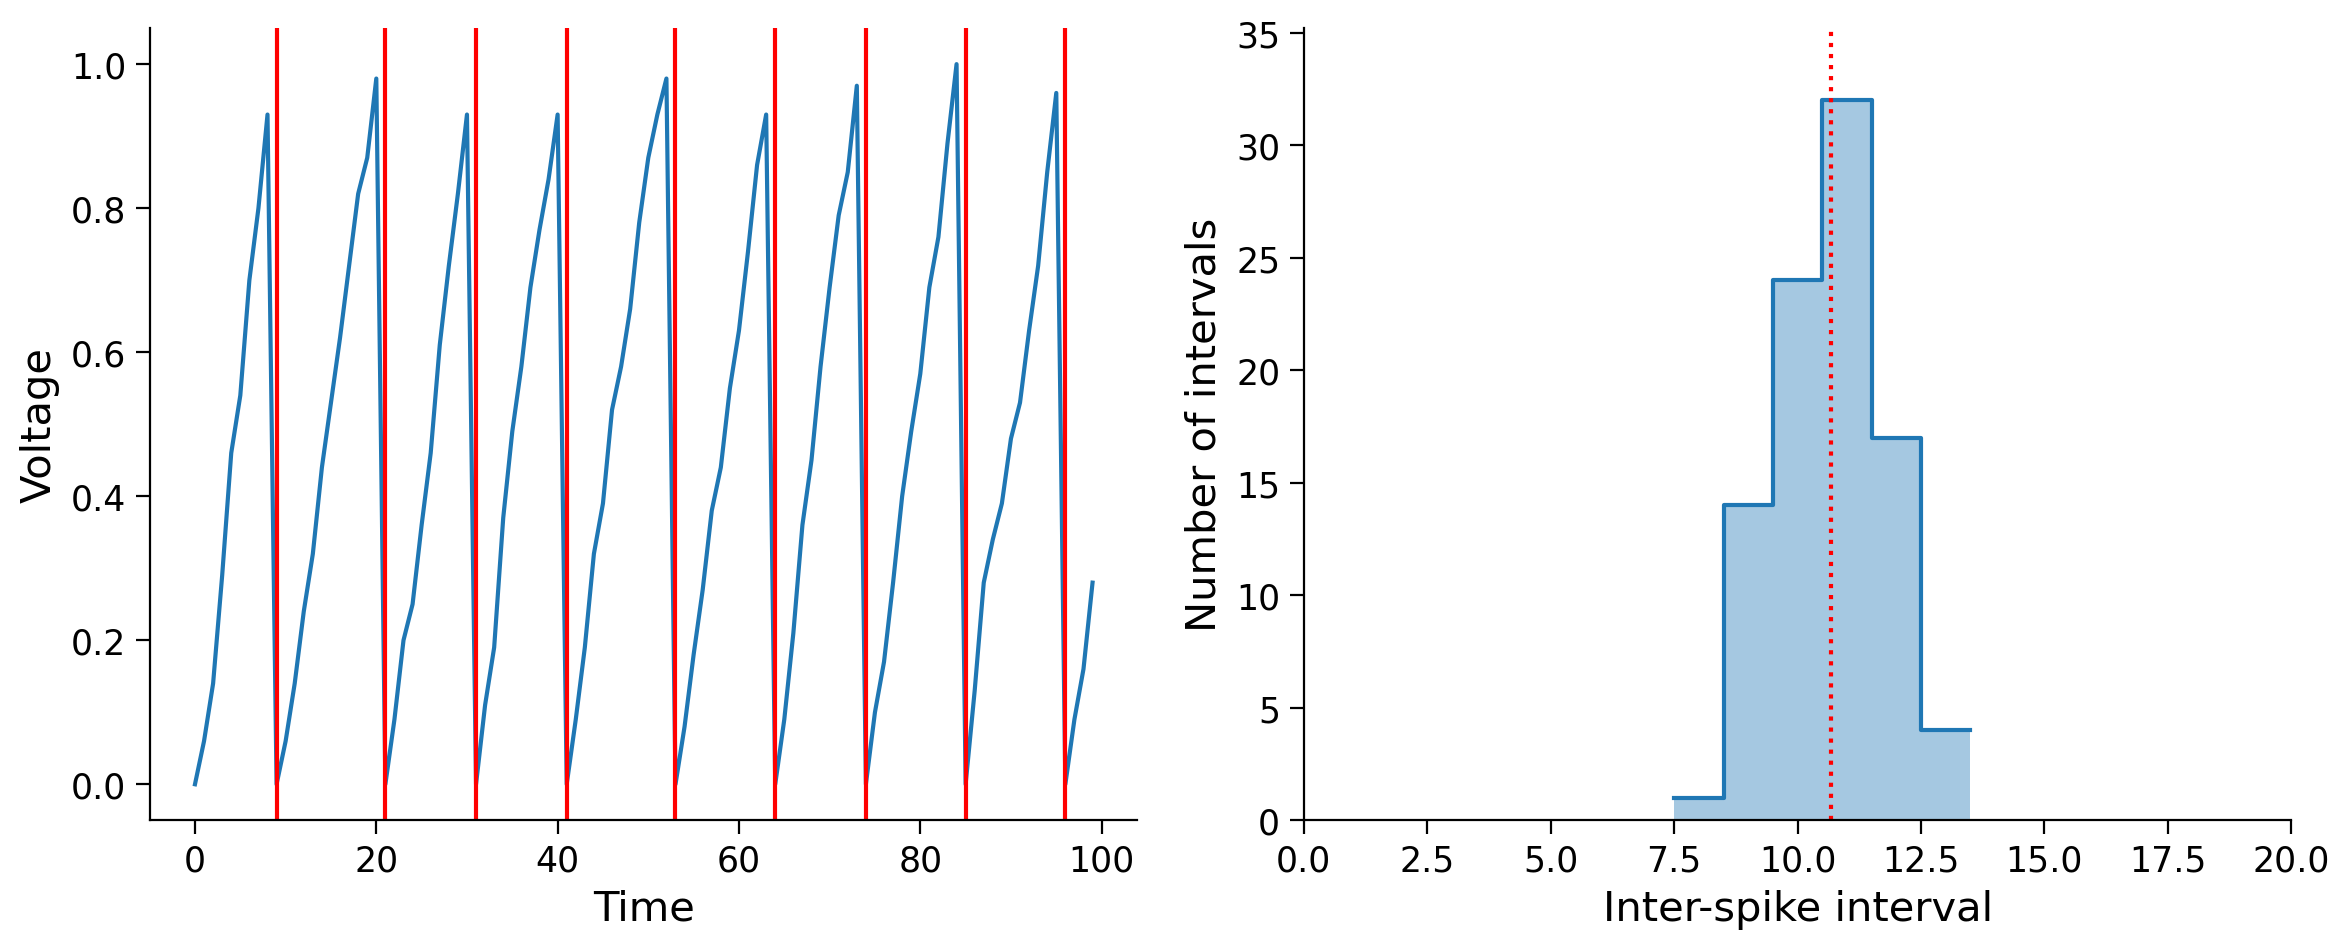

In [32]:
def lif_neuron(n_steps=1000, alpha=0.01, rate=10):
  """ Simulate a linear integrate-and-fire neuron.

  Args:
    n_steps (int): The number of time steps to simulate the neuron's activity.
    alpha (float): The input scaling factor
    rate (int): The mean rate of incoming spikes

  """
  exc = stats.poisson(rate).rvs(n_steps)
  v = np.zeros(n_steps)
  spike_times = []
  for i in range(1, n_steps):
    dv = alpha * exc[i-1]
    v[i] = v[i-1] + dv
    if v[i] > 1:
      spike_times.append(i)
      v[i] = 0

  return v, spike_times

# Set random seed (for reproducibility)
np.random.seed(12)
# Model LIF neuron
v, spike_times = lif_neuron()
# Visualize
plot_neuron_stats(v, spike_times)

## Vary alpha, which is input scaling factor, and rate, which is the mean rate of incoming spikes.
1. What is the spiking pattern of this model?

2. What effect does raising or lowering alpha have?

3. What effect does raising or lowering the rate have?


In [33]:
def _lif_neuron(n_steps=1000, alpha=0.01, rate=10):
  exc = stats.poisson(rate).rvs(n_steps)
  v = np.zeros(n_steps)
  spike_times = []
  for i in range(1, n_steps):
    dv = alpha * exc[i]
    v[i] = v[i-1] + dv
    if v[i] > 1:
      spike_times.append(i)
      v[i] = 0
  return v, spike_times

@widgets.interact(
  alpha=widgets.FloatLogSlider(0.01, min=-2, max=-1),
  rate=widgets.IntSlider(10, min=5, max=20)
)
def plot_lif_neuron(alpha=0.01, rate=10):
  v, spike_times = _lif_neuron(2000, alpha, rate)

  plot_neuron_stats(v, spike_times)

interactive(children=(FloatLogSlider(value=0.01, description='alpha', max=-1.0, min=-2.0), IntSlider(value=10,…

## LIF + Inhibition Neuron

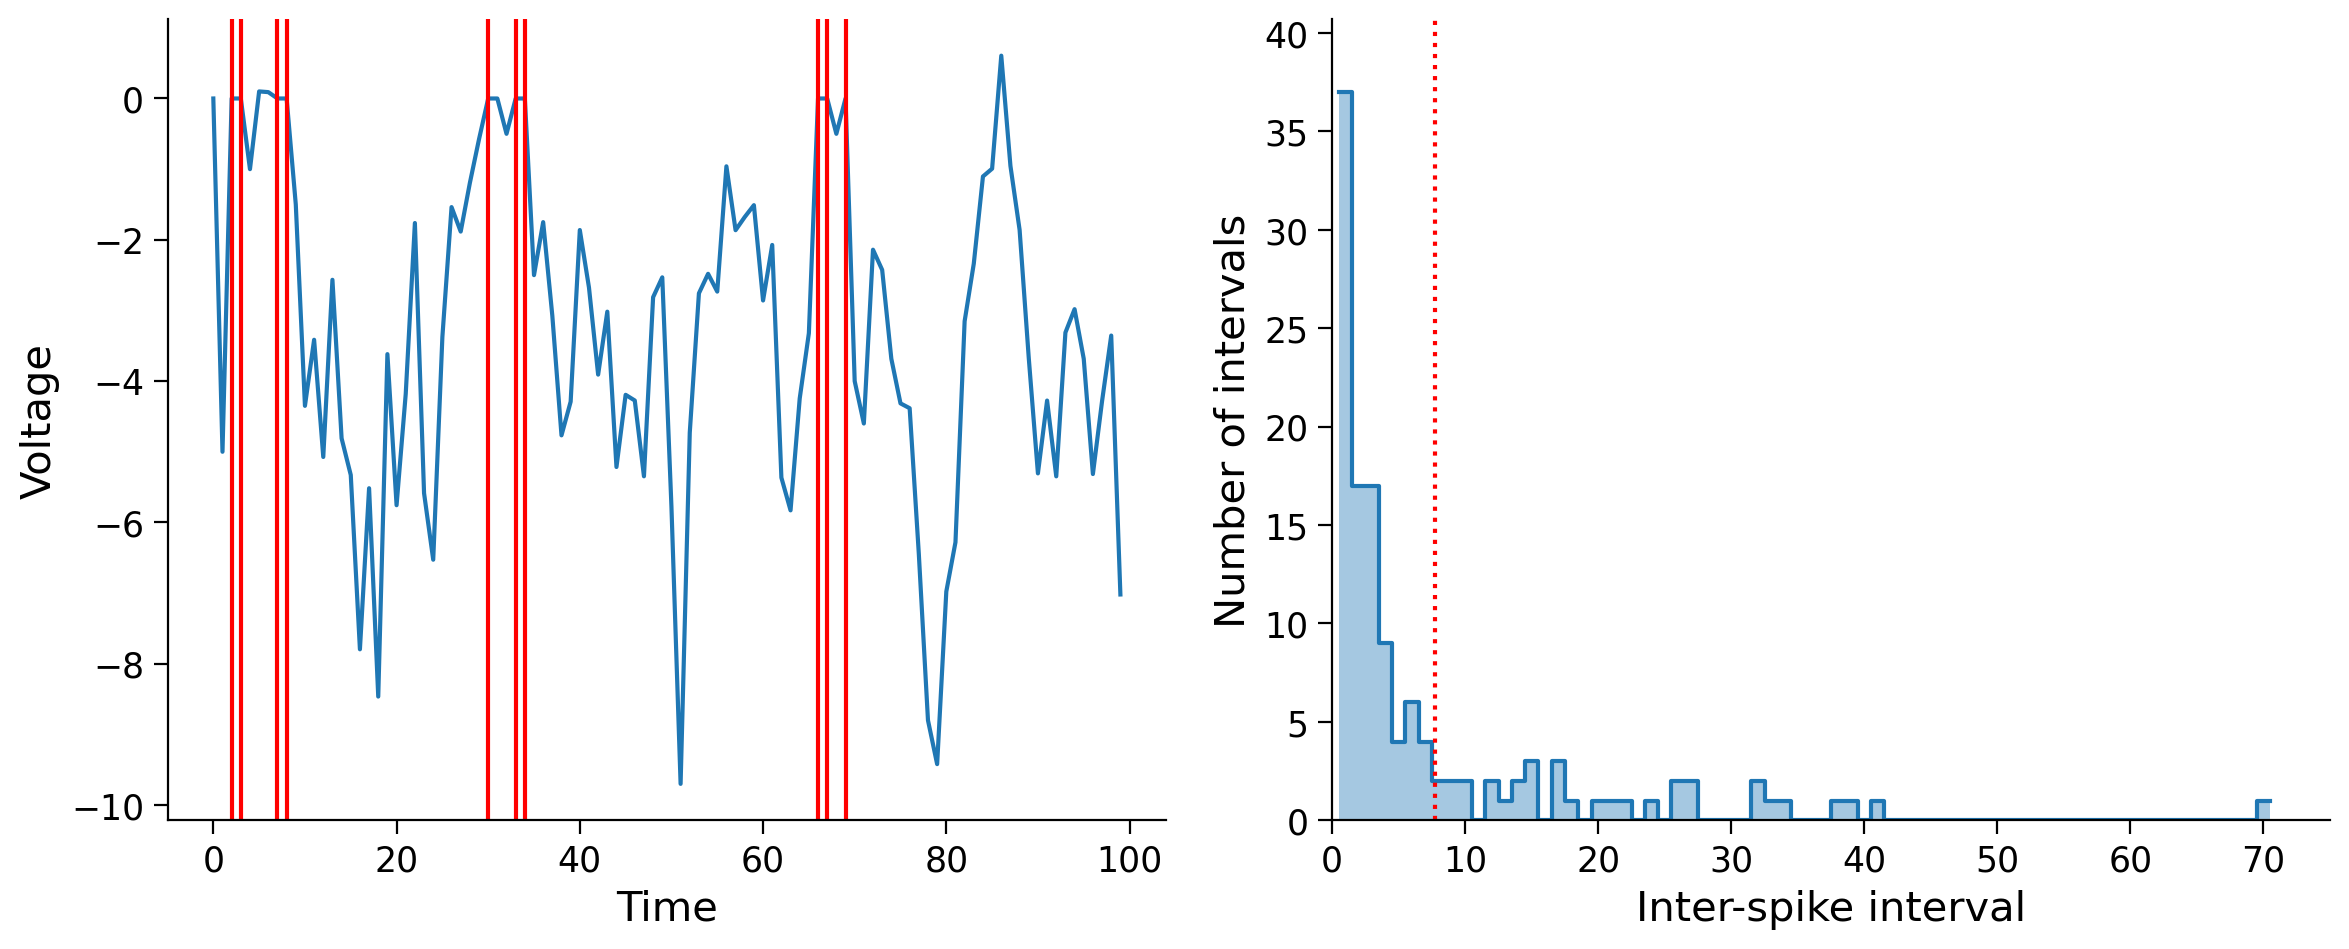

In [34]:
def lif_neuron_inh(n_steps=1000, alpha=0.5, beta=0.1, exc_rate=10, inh_rate=10):
  """ Simulate a simplified leaky integrate-and-fire neuron with both excitatory
  and inhibitory inputs.

  Args:
    n_steps (int): The number of time steps to simulate the neuron's activity.
    alpha (float): The input scaling factor
    beta (float): The membrane potential leakage factor
    exc_rate (int): The mean rate of the incoming excitatory spikes
    inh_rate (int): The mean rate of the incoming inhibitory spikes
  """
  exc = stats.poisson(exc_rate).rvs(n_steps)
  inh = stats.poisson(inh_rate).rvs(n_steps)

  v = np.zeros(n_steps)
  spike_times = []

  for i in range(1, n_steps):

    dv = -beta * v[i-1] + alpha * (exc[i] - inh[i])

    v[i] = v[i-1] + dv
    if v[i] > 1:
      spike_times.append(i)
      v[i] = 0

  return v, spike_times

# Set random seed (for reproducibility)
np.random.seed(12)
# Model LIF neuron
v, spike_times = lif_neuron_inh()
# Visualize
plot_neuron_stats(v, spike_times)